
<h1 style="font-size":40px>Parameter Estimation and Market Risk with Merton Jump-Diffusion Model(Single Asset)</h1>


<h2 style = "font-size:25px"><ins>THEORY</ins></h2> 

<h3> Jump Diffusion Model</h3>

<p>The Merton jump-diffusion model predicts the price movements of an asset via a Stochastic Differential Equation(SDE)<a href="#ref1"><sup>[1]</sup></a>:


<a id="eq-merton"></a>
$$
\begin{equation}
d S_t = (\mu -\lambda K)S_t dt + \sigma S_t dW_t + S_t(J-1)dN_t \tag{1}
\end{equation}
$$
  
The first term captures a deterministic, linear change in asset price. The second term adds a continuous, fluctuating component, modeled by a Wiener process: 
    $$
    dW_t = \mathcal{N}(0,d t)= \sqrt{d t} \mathcal{N}(0,1)    
    $$
The final term represents a discontinuous jump, characterized by a frequency(encoded in $dN_t$) and a magnitude($J$). Merton assumes that $J$ is lognormally distributed:
    $$
    \text{ln}(J) \sim \mathcal{N}(\mu_J,\sigma^2_J)
    $$
whereas $dN_t$ is a Poisson process of intensity $\lambda$. This means that probability that the Poisson process returns an integer $k$(corresponding to $k$ jumps) is

$$
P(dN_t = k) = \frac{(\lambda dt)^k}{k!} e^{-\lambda dt}
$$

The drift term in the Black-Scholes model is only $\mu$ but the extra term here accounts for the contribution of the jump terms as well. Note that $K = \mathbb{E}[J-1]$, which means under the assumption of log-normality, that $K = \exp\left(\mu_J + \frac{\sigma_J^2}{2} \right) -1$. On the other hand, $\lambda dt$ is the average of the Poisson process $dN_t$, so their product provides the average of the jump term as a whole.

We now introduce the coordinate $X_t = \text{ln}(S_t)$, and transform the above SDE accordingly. For the first two terms, we use the following result
$$
dX_t =  \frac{\partial X_t}{\partial S}{dS} + \frac{\partial^2 X_t}{\partial S^2}{d S^2} 
$$ 
which is obtained by applying a second order Taylor expansion and setting $\partial_t X_t = 0$. Thereafter, noting that $d W_t \sim\mathcal{O}(\sqrt{dt})$ and neglecting all powers of $dt$ greater than 1 leads to Itô's lemma:

$$
\begin{equation*}
d X_t = \left( \mu - \lambda K - \frac{\sigma^2}{2}\right) dt + \sigma dW_t 
\end{equation*}
$$
To account for the jump term, we can directly transform its induced differential $dS$ in the new coordinate, which works out to $[\ln(J S_t) - \ln(S_t)]dN_t$. Putting everything together yields

<a id="eq-merton-y"></a>
$$
\begin{equation}
d X_t = \left( \mu - \lambda K -\frac{\sigma^2}{2}\right) dt + \sigma dW_t + \ln(J) dN_t\tag{2}
\end{equation}
$$
While this equation can be analytically integrated over time, we will solve it numerically. The discretized version of <a href="#eq-merton-y">(2)</a> reads
$$
X_{t+ \Delta t} = X_t + \left( \mu - \lambda K -\frac{\sigma^2}{2} \right) \Delta t + \sigma \mathcal{N}(0,\sqrt{\Delta t}) + N_{\Delta t} \mathcal{N}(\mu_J,\sigma^2)
$$
where $N_{\Delta t}$ is the discrete version of $dN_t$ defined above.
I chose to work with $S_t$ itself, so I write

<a id="eq-merton-final"></a>
$$
\begin{equation}
S_{t+\Delta t} = S_t e^{\left( \mu - \lambda K -\frac{\sigma^2}{2} \right) \Delta t + \sigma  \mathcal{N}(0,\sqrt{\Delta t}) + N_{\Delta t} \mathcal{N}(\mu_J,\sigma^2)} \tag{3}
\end{equation}
$$
<h3>Parameter Estimation</h3>
To model an asset with the jump-diffusion model requires five parameters $(\mu,\sigma,\mu_J,\sigma_J,\lambda)$. These parameters can be estimated using historical asset data, by applying maximum likelihood estimation. The  probability density function for log-returns $X_t = \ln(S_t/S_0)$ under the jump diffusion model is given by<a href="#ref2"><sup>[2]</sup></a>
$$
P(X_t) = \sum_{i=0}^{\infty} \frac{e^{-\lambda t} (\lambda t)^i}{i!} \mathcal{N}\left( X_t; \left(\mu - \frac{\sigma^2}{2} - \lambda K  \right) + i\mu_J, \sigma^t + i \sigma_J^2 \right)
$$

The corresponding likelihood function is 
$$
L(\theta;Y) = \prod_{t=1}^T P(X_t)
$$

but it's more convenient to work with the logarithm:
$$
\ln[P(\theta;Y)] = \sum_{t=1}^T \ln[P(X_t)]
$$

Maximizing this function by minimizing $-\ln[L(\theta;Y)]$ gives us the optimal parameters for the given data.

<h2 style= "font-size":25px><ins>CODE</ins></h2>

<h3>Parameter Estimation</h3>
To implement this model on Python, we first import a few modules. 

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import factorial
import time
import multiprocessing as mp
import seaborn as sns

The class in the cell below estimates the parameters by minimizing the negative log of the likelihood function $-\ln[L(\theta;Y)]$ using $\texttt{scipy.optimize}$'s implementation of the <a href="medium.com/data-science/numerical-optimization-based-on-the-l-bfgs-method-f6582135b0ca"> limited-memory BFGS(B) algorithm </a>. It consists of four methods:

 * ```PDF_normal```: returns the probability density function for normally distributed jumps
 * ```Likelihood```: returns $-\ln[L(\theta;Y)]$ given log returns and the five parameters
 * ```estimate_parameters```: estimates the five parameters by minimizing $-\ln[L(\theta;Y)]$

In [2]:
class JD_Param_Est:
    """
    A class to estimate parameters for the Merton Jump-Diffusion model
    using historical stock price data.
    """

    #dictionary for later extensions to other PDFs
    PDF_METHOD_NAMES = {"normal": "PDF_normal",}

    def __init__(self,log_returns, Δt=1/252, pdf_type="normal"):
        """
        Initializes class variables: ticker, date range, time step, PDF for MLE
        """
        self.Δt = Δt
        self.log_returns = log_returns
        self.estimated_params = None
        if pdf_type not in self.PDF_METHOD_NAMES:
            raise ValueError(f"Unknown PDF type: '{pdf_type}'. Available types are: {list(self.PDF_METHOD_NAMES.keys())}")
        
        self.PDF_method = self.PDF_METHOD_NAMES[pdf_type] 


    def PDF_normal(self, X_t_i, k, μ, σ, μ_J, σ_J, λ, Δt):
        """
        PDF for normally distributed jumpts
        """
        #Poisson probability for k jumps
        p_Poisson = (np.exp(-λ * Δt) * (λ * Δt)**k / factorial(k))

        K = np.exp(μ_J + 0.5 * σ_J**2) - 1

        drift = (μ - λ * K - σ**2 / 2) * Δt + k * μ_J
        total_variance = σ**2 * Δt + k * σ_J**2

        
        if total_variance <= 1e-12:
            return 1e-300 #return tiny positive number to avoid errors

        #Normal probability density function for the log-return
        normal_pdf_component = (1 / np.sqrt(2 * np.pi * total_variance)) * \
                               np.exp(-(X_t_i - drift)**2 /
                                      (2 * total_variance))

        return p_Poisson * normal_pdf_component

    def Likelihood(self, params, X_t, Δt):
        """
        Calculates the negative log-likelihood for the PDF chosen in init.
        Input:
            params (tuple): A tuple of (μ, σ, μ_J, σ_J, λ).
            X_t (np.ndarray): Array of log returns.
            Δt (float): Time step.

        Output:
            float: The negative log-likelihood value.
        """
        μ, σ, μ_J, σ_J, λ = params

        n = len(X_t)
        num_jumps = 5
        f = np.zeros((n, num_jumps)) #maximum of 10 jumps 

        #get the selected PDF method for this instance
        jump_PDF = getattr(self, self.PDF_method)

        for i in range(n):
            for k in range(num_jumps):  
                f[i, k] = jump_PDF(X_t[i], k, μ, σ, μ_J, σ_J, λ, Δt)
            
        #sum over all k's
        R = np.sum(f, axis=1)

        #handle R=0 to avoid log(0) error
        R[R <= 0] = 1e-300

        LL = -np.sum(np.log(R))  #negative log-likelihood
        return LL

    def estimate_parameters(self, initial_guess=None, max_iter=5000):
        """
        Estimate the parameters of Jump-Diffusion model via MLE
        """
        print("\nParameter estimation in progress...")
        start_time = time.time()

        if initial_guess is None:
            initial_guess = np.array([1,1,1,1,1]) # μ, σ, μ_J, σ_J, λ
        
        #the means are unbounded, but σ, σ_J, and λ must be positive.
        bounds = [
            (-np.inf, np.inf), # μ
            (1e-6, np.inf),    # σ
            (-np.inf, np.inf), # μ_J
            (1e-6, np.inf),    # σ_J
            (1e-6, np.inf)     # λ
        ]

        estimation = minimize(self.Likelihood, initial_guess, args=(self.log_returns, self.Δt),
                              method='L-BFGS-B', bounds=bounds,
                              options={'disp': False, 'maxiter': max_iter})

        end_time = time.time()
        print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

        self.estimated_params = estimation.x
        return self.estimated_params
    

To check the efficacy of the optimization, we can simulate the stock data with the Merton model <a href="#eq-merton-final">(3)</a> and estimate its parameters with the methods defined in the class ```JD_Param_Est```. To do that, we define a new function.

In [3]:
def Merton_log_return(params,S0, Δt,n_steps):
    μ, σ, μ_J, σ_J, λ = params
    St = np.zeros(n_steps + 1)
    St[0] = S0
    for i in range(1, n_steps + 1):
        
        num_jumps = np.random.poisson(λ * Δt)
        jump_component = np.sum(np.random.normal(μ_J, σ_J, num_jumps)) #sum over all jumps
        diffusion_component = σ * np.sqrt(Δt) * np.random.normal()
        K = np.exp(μ_J + 0.5 * σ_J**2) - 1
        #calculate next price
        St[i] = St[i-1] * np.exp((μ - 0.5 * σ**2 -λ*K) * Δt + diffusion_component + jump_component)

    log_returns = np.diff(np.log(St))
    return log_returns

For $(\mu,\sigma,\mu_J,\sigma_J,\lambda) = (2,1.5,0.1,0.3,40)$, $S_0 = 100$ and ```n_steps = 1000```, we simulate log returns 100 times and estimate the parameters for each run. 

In [4]:
# #uncomment to run this cell(takes 5-10 minutes)
# sim_pars = (2,1.5,0.1,0.3,40)
# n_steps = 1000
# S0 = 100
# Δt = 1/252

# ns = 100
# est_pars = np.zeros((ns,5))
# for i in range(ns):
#     s_r = Merton_log_return(sim_pars,S0,Δt,n_steps)
#     Model = JD_Param_Est(s_r, Δt, pdf_type="normal")
#     print(f"{i}/{ns}")
#     est_pars[i,:] = Model.estimate_parameters()
# μ, σ, μ_J, σ_J, λ = np.mean(est_pars,axis=0)

The average values are tabulated below, showing excellent agreement on all parameters. 

| Parameter                 | μ  | σ  | μ_J  | σ_J  | λ |
| :------------------------ | :-------- | :---------------------- | :-------------- | :-------------------- | :----------------- |
| **Simulated** | 2.0       | 1.5                     | 0.1             | 0.3                   | 40.0               |
| **Estimated** | 2.08  | 1.51                | 0.11        | 0.29              | 38.5          |

With our code validated, we can now test it on real data. We use the example given in the paper by Hanson and Zhu<a href="#ref3"><sup>[3]</sup></a>, where jump-diffusion parameters are estimated for various models using $\bf{}S\&P \ 500$ data from $\bf{}01/01/1991$ to $\bf{}31/12/2001$. The table below compares four parameters provided in that paper&mdash; the mean of the date(M1), the variance (M2), the skewnewss ($\beta_3$) and the excess kurtosis ($\beta_4$)&mdash; to the corresponding parameters for our $\texttt{yfinance}$ data. Since the values we've obtained are close enough, we expect the estimated parameters to be roughly reproduced.

| Parameter | M1                | M2                | β₃        | β₄       |
| :-------- | :---------------- | :---------------- | :-------- | :------- |
| **Reference** | 4.05e-4 | 9.869e-5 | -0.2925 | 4.826 |
| **Current Code**| 4.015e-4          | 9.874e-5          | -0.2913   | 4.804    |

In [5]:
ticker = '^GSPC'
start = '1992-01-01'
stop = '2001-12-31'
Δt = 1/252
data = yf.download(ticker, start, stop, progress=False)
prices = data['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns = log_returns[ticker].to_numpy()
Model = JD_Param_Est(log_returns, Δt, pdf_type="normal")
estimated_parameters = Model.estimate_parameters()

μ, σ, μ_J, σ_J, λ = estimated_parameters
print(f"\n--- Estimated Merton Parameters for {ticker} from {start} to {stop}---")
print(f"μ (Drift): {μ:.6f}")
print(f"σ (Brownian Volatility): {σ:.6f}")
print(f"μ_J (Jump Mean): {μ_J:.6f}")
print(f"σ_J (Jump Volatility): {σ_J:.6f}")
print(f"λ (Jump Intensity): {λ:.6f}")

YF.download() has changed argument auto_adjust default to True

Parameter estimation in progress...
Optimization finished in 17.29 seconds.

--- Estimated Merton Parameters for ^GSPC from 1992-01-01 to 2001-12-31---
μ (Drift): 0.114179
σ (Brownian Volatility): 0.084838
μ_J (Jump Mean): -0.000601
σ_J (Jump Volatility): 0.011217
λ (Jump Intensity): 135.386322


| Parameter                | μ | σ | μ_J | σ_J  | λ  |
| :----------------------- | :-------- | :---------------------- | :-------------- | :-------------------- | :----------------- |
| **Reference** | 0.114     | 0.088                   | -0.000709       | 0.0119                | 121                |
| **Current Code** | 0.114  | 0.084                | -0.00060       | 0.0112              | 135         |

The results are within ~$10\%$ of each other for most parameters except $\mu_J$ and $\lambda$, which could be down to slight differences in methods and underlying data. The cell below plots the empirical returns alongside the simulated returns to provide a visual perspective on how well we've estimated the parameters. Note that the simulated returns are not deterministic, so we should not look for a perfect fit, but rather an approximate one. For risk management purposes, it suffices if the tails are well accounted for.

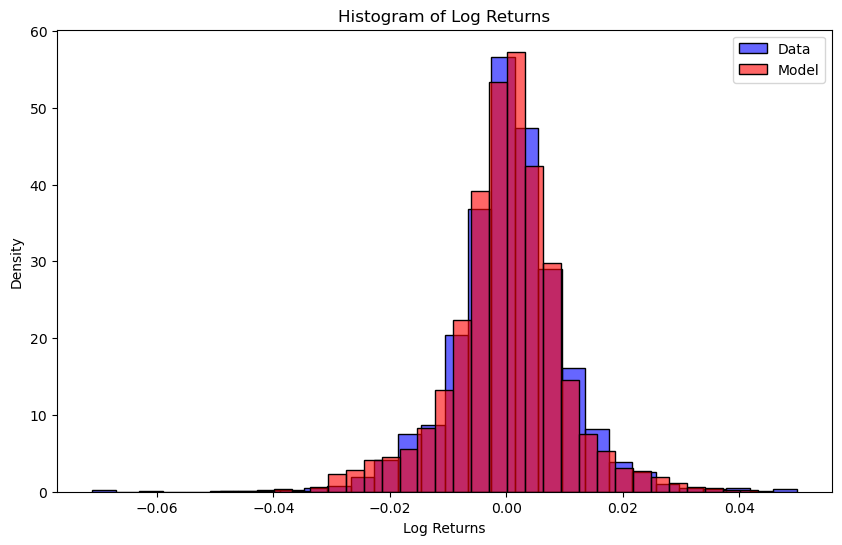

In [6]:
S0 =  prices.iloc[0,0]
n_steps = len(log_returns)
sim_returns = Merton_log_return(estimated_parameters,S0,Δt,n_steps) 
plt.figure(figsize=(10, 6))
sns.histplot(log_returns, bins=30, stat='density', alpha=0.6, color='blue', label='Data', kde=False)
sns.histplot(sim_returns, bins=30, stat='density', alpha=0.6, color='red', label='Model', kde=False)
plt.title('Histogram of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Density') 
plt.legend()

Next, we write a function to calculate stock prices via Monte Carlo simulations. The parameters estimated above are plugged into equation <a href="#eq-merton-final">(3)</a> to calculate the evolution of the stock price as per the Merton jump-diffusion model. The price is sequentially calculated for a time horizon of ```n_days```(days), and the simulation is repeated ```n_runs``` times. 

Since the calculations can take up significant time and memory, we shall parallelize them using Python's $\texttt{multiprocessing}$ module by splitting up ```Merton_log_return```. This approach works well for very large time horizons and number of runs even on a laptop, where memory constraints might have prevented the code from executing had a 2D array to leverage $\texttt{numpy}$'s vectorized operations. Note that each run has its own random seed, but the set of seeds is fixed, allowing for reproducable results

In [7]:
class Monte_Carlo:
    def __init__(self,params,S0,Δt,n_runs,n_days):
        self.params = params
        self.S0 = S0
        self.Δt = Δt
        self.n_runs = n_runs
        self.n_days = n_days+1
        self.simulated_returns = None
        self.simulated_paths = None

    def simulate_path(self,seed):
        μ, σ, μ_J, σ_J, λ  = self.params
        np.random.seed(seed)         #ensures different random numbers for each run
        s_M = np.zeros(self.n_days)       #stores data for one run
        s_M[0] = self.S0
        K = np.exp(μ_J + 0.5 * σ_J**2) - 1
        for j in range(1, self.n_days):
            num_jumps = np.random.poisson(λ * self.Δt)
            jump_component = np.sum(np.random.normal(μ_J, σ_J, num_jumps)) #sum over all jumps
            diffusion_component = σ * np.sqrt(Δt) * np.random.normal()
            s_M[j] = s_M[j - 1] * np.exp((μ - 0.5 * σ**2 -λ*K) * Δt + diffusion_component + jump_component)
        return_m = np.log(s_M[-1]/s_M[0]) 
        if(seed % 100==0):
            return return_m,s_M
        else:
            return return_m,None

    def collect_returns(self):
        #use multiprocessing to parallelize the simulations
        with mp.Pool(processes=mp.cpu_count()) as pool:
            results = pool.starmap(self.simulate_path,[(seed,) for seed in range(n_runs)])
        #collect returns
        self.simulated_returns = np.array([res[0] for res in results])
        self.simulated_paths = np.array([res[1] for res in results if res[1] is not None])
        return self.simulated_returns,self.simulated_paths

In [8]:
n_runs = 100000                         #number of Monte Carlo runs
n_days = 30                             #time horizon
confidence_level = 0.95                 #set confidence level for VaR

MC = Monte_Carlo(estimated_parameters,S0,Δt,n_runs,n_days) 
sim_returns,sim_paths = MC.collect_returns()

Once the simulated returns are available, we can calculate and visualize the Value at Risk and Expected Shortfall using the functions defined below.

In [9]:
def VaR_ES(returns,confidence_level):

    VaR = np.percentile(returns, 100*(1-confidence_level))  
    ES = returns[returns <= VaR].mean()
    return VaR,ES 

def plot_returns(sim_returns,confidence_level,VaR,ES,n_days):
    fig, ax = plt.subplots(figsize=(10, 6))    
    #histogram of portfolio returns
    sns.histplot(sim_returns, bins=50,stat='density', color="black", alpha=0.6, label="Simulated Returns")
    #show VaR
    ax.axvline(VaR, color='blue', linestyle='dashed', linewidth=2, label=f'Value at Risk $({VaR:.4f})$')
    ax.axvline(ES, color='red', linestyle='dashed', linewidth=2, label=f'Expected Shortfall $({ES:.4f})$')

    ax.set_title(r"Histogram of Simulated Returns with {}-day VaR and ES at ${}\%$ Confidence".format(n_days,confidence_level*100))
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

def plot_paths(sim_paths, S0, confidence_level, VaR, ES, n_days):

    fig, ax = plt.subplots(figsize=(12, 7))
    #plot all given paths
    for i in range(sim_paths.shape[0]):
        ax.plot(sim_paths[i, :], alpha=0.3, linewidth=0.8) 
    VaR_price = S0 * (1 + VaR)
    ES_price = S0 * (1 + ES)

    #plot VaR and ES
    ax.axhline(VaR_price, color='blue', linestyle='dashed', linewidth=2,label=f'VaR ({int(confidence_level*100)}%): {VaR:.2%}')
    ax.axhline(ES_price, color='red', linestyle='dashed', linewidth=2,label=f'ES ({int(confidence_level*100)}%): {ES:.2%}')    
    # plot initial price
    ax.axhline(S0, color='green', linestyle='-', linewidth=1.5, label='Initial Price ($S_0$)')

    ax.set_title(r"Simulated Stock Prices with {}-day VaR and ES at ${}\%$ Confidence".format(n_days, int(confidence_level * 100)))
    ax.set_xlabel("Days")
    ax.set_ylabel("Simulated Price")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


To demonstrate, the cell below calculates the 30-day VaR and ES based on the parameters we've estimated for the decade 1992-2001.

VaR at 95.0%(Merton Jump-Diffusion): -7.69% 
ES at 95.0%(Merton Jump-Diffusion): -10.05%


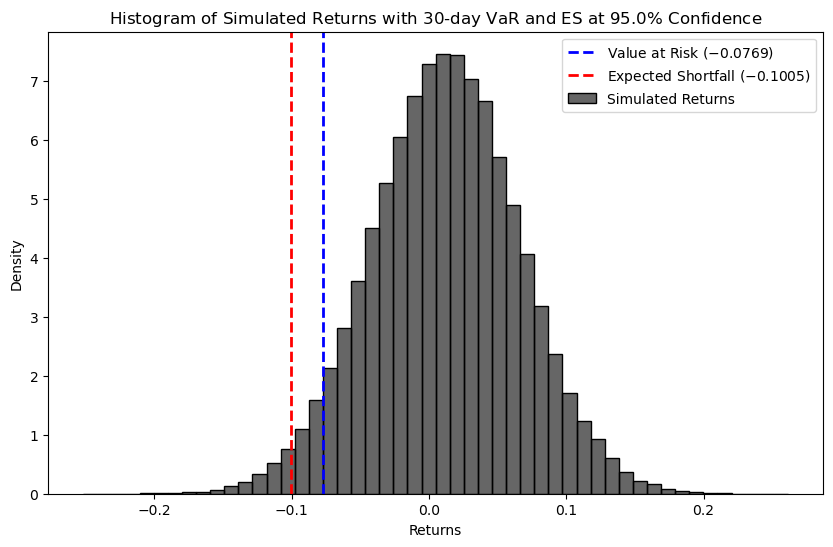

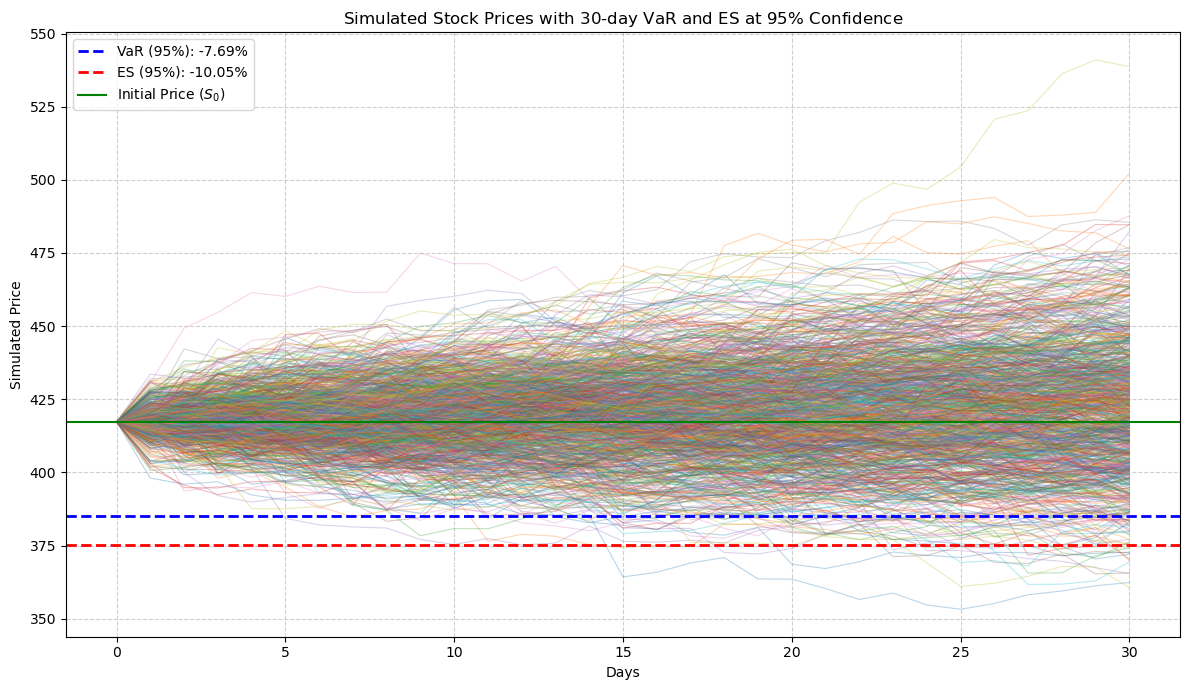

In [10]:
VaR, ES = VaR_ES(sim_returns, confidence_level)
print(f"{"\033[1m"}VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*VaR:.2f}% {"\033[0m"}")
print(f"{"\033[1m"}ES at {confidence_level*100}%(Merton Jump-Diffusion): {100*ES:.2f}%{"\033[0m"}")
plot_returns(sim_returns,confidence_level,VaR,ES,n_days)
plot_paths(sim_paths, S0, confidence_level, VaR, ES, n_days)

This is a reasonable value, but let's see what happens if we model the asset with parameters from a time of financial distress. For this purpose, we consider data from the 2008 financial crisis, with a window of one year from September 2008. 

In [11]:
t1 = '2008-09-01' 
t2 = '2009-09-01'

s_data = yf.download(ticker, t1, t2, progress=False)
s_prices = s_data['Close']
s_log_returns = np.log(s_prices / s_prices.shift(1)).dropna()
s_log_returns = s_log_returns[ticker].to_numpy()
stress_Model = JD_Param_Est(s_log_returns, Δt, pdf_type="normal")
stress_params = stress_Model.estimate_parameters()
s_μ, s_σ, s_μ_J, s_σ_J, s_λ = stress_params

print(f"\n--- Estimated Merton Parameters for {ticker} from {t1} to {t2}---")
print(f"μ (Drift): {s_μ:.6f}")
print(f"σ (Brownian Volatility): {s_σ:.6f}")
print(f"μ_J (Jump Mean): {s_μ_J:.6f}")
print(f"σ_J (Jump Volatility): {s_σ_J:.6f}")
print(f"λ (Jump Intensity): {s_λ:.6f}")


Parameter estimation in progress...
Optimization finished in 0.60 seconds.

--- Estimated Merton Parameters for ^GSPC from 2008-09-01 to 2009-09-01---
μ (Drift): -0.122942
σ (Brownian Volatility): 0.452751
μ_J (Jump Mean): 2.774998
σ_J (Jump Volatility): 0.289386
λ (Jump Intensity): 0.000001


<b>The drift here is appreciably worse than before, as is the volatility. </b>On the other hand, the jumps are estimated to be positive but rare, ensuring that they make little difference in countering the strong negative drift. Let's calculate the 30-day VaR and ES for these parameters.

VaR at 95.0%(Merton Jump-Diffusion): -28.32% 
ES at 95.0%(Merton Jump-Diffusion): -35.01%


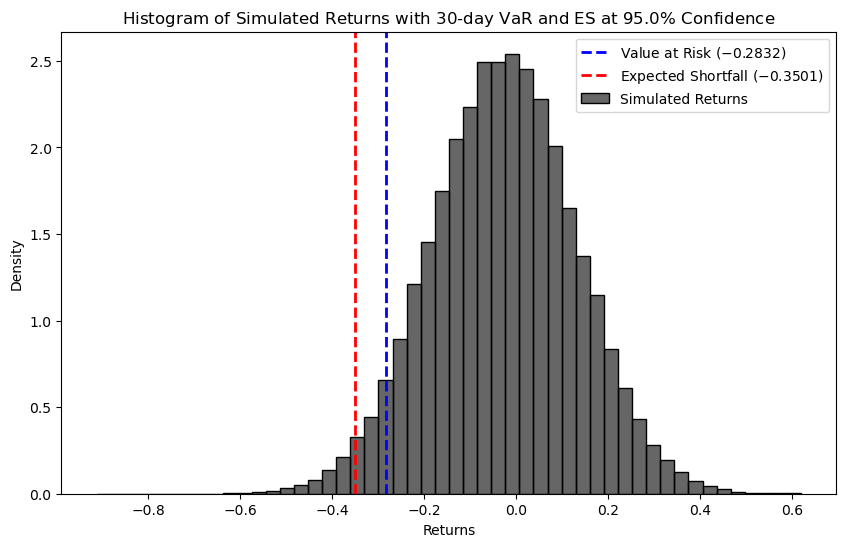

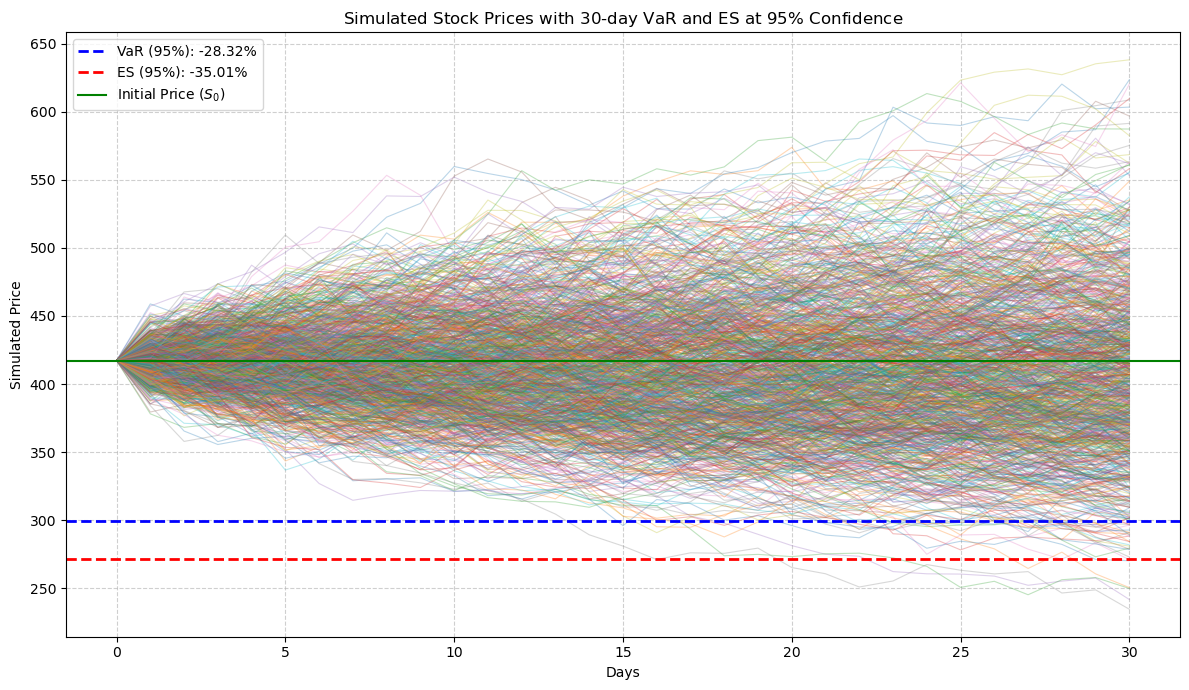

In [12]:
#stress parameters
s_MC = Monte_Carlo(stress_params,S0,Δt,n_runs,n_days)  #use same MC metrics as before
s_returns,s_paths = s_MC.collect_returns() 
s_VaR, s_ES = VaR_ES(s_returns, confidence_level)
print(f"{"\033[1m"}VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*s_VaR:.2f}% {"\033[0m"}")
print(f"{"\033[1m"}ES at {confidence_level*100}%(Merton Jump-Diffusion): {100*s_ES:.2f}%{"\033[0m"}")
plot_returns(s_returns,confidence_level,s_VaR,s_ES,n_days)
plot_paths(s_paths, S0, confidence_level, s_VaR, s_ES, n_days)

The potential losses are about 3-4 times as worse as before, which is to be expected given the period for which these parameters were estimated. The returns also clearly skew to the left, in line with data from a financial crisis.

## References

<a id="ref1"></a>[1] Matsuda, Kazuhisa. "<a href="https://maxmatsuda.com/Papers/Intro/Intro%20to%20MJD%20Matsuda.pdf">*Introduction to Merton jump diffusion model*</a>" Department of Economics, The Graduate Center, The City University of New York, New York (2004).

<a id="ref2"></a>[2] Matsuda, Kazuhisa. "<a href="etd.lib.metu.edu.tr/upload/12623378/index.pdf">*Parameter Estimation in Merton Jump Diffusion Model*</a>" The Graduate School of Natural and Applied Sciences, Middle East Technical University.


<a id="ref3"></a>[3] F. B. Hanson and Zongwu Zhu, "<a href="https://ieeexplore.ieee.org/document/1429353">*Comparison of market parameters for jump-diffusion distributions using multinomial maximum likelihood estimation*</a>", 2004 43rd IEEE Conference on Decision and Control (CDC) (IEEE Cat. No.04CH37601), Nassau, Bahamas, 2004, pp. 3919-3924 Vol.4, doi: 10.1109/CDC.2004.1429353.